In [1]:
!pip install mlxtend
!pip install xgboost
!pip install lightgbm
!pip install catboost
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)
  Using cached catboost-1.0.5-cp39-none-win_amd64.whl (73.9 MB)
  Using cached plotly-5.7.0-py2.py3-none-any.whl (28.8 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [2]:
!pip install openpyxl

In [3]:
#Load data
df_inf = pd.read_csv("C:/Users/mkush/Downloads/PCOS_infertility.csv")
df_woinf = pd.read_excel("C:/Users/mkush/Downloads/PCOS_data_without_infertility.xlsx",sheet_name="Full_new")

In [4]:
#Look at the data with infertile patients.
df_inf.head()

Sl. No  Patient File No.  PCOS (Y/N)    I   beta-HCG(mIU/mL)  \
0       1             10001           0                    1.99   
1       2             10002           0                   60.80   
2       3             10003           1                  494.08   
3       4             10004           0                    1.99   
4       5             10005           0                  801.45   

   II    beta-HCG(mIU/mL) AMH(ng/mL)  
0                    1.99       2.07  
1                    1.99       1.53  
2                  494.08       6.63  
3                    1.99       1.22  
4                  801.45       2.26

In [5]:
#Look at the data with non-infertile patients.
df_woinf.head()

Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0     1.0               1.0         0.0        28.0         44.6        152.0   
1     2.0               2.0         0.0        36.0         65.0        161.5   
2     3.0               3.0         1.0        33.0         68.8        165.0   
3     4.0               4.0         0.0        37.0         65.0        148.0   
4     5.0               5.0         0.0        25.0         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000         15.0              78.0              22.0  ...   
1  24.921163         15.0              74.0              20.0  ...   
2  25.270891         11.0              72.0              18.0  ...   
3  29.674945         13.0              72.0              20.0  ...   
4  20.060954         11.0              72.0              18.0  ...   

   Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0              1.0                0.0                110.0   
1              0.0                0.0                120.0   
2              1.0                0.0                120.0   
3              0.0                0.0                120.0   
4              0.0                0.0                120.0   

   BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                  80.0               3.0               3.0   
1                  70.0               3.0               5.0   
2                  80.0              13.0              15.0   
3                  70.0               2.0               2.0   
4                  80.0               3.0               4.0   

   Avg. F size (L) (mm) Avg. F size (R) (mm)  Endometrium (mm)  Unnamed: 44  
0                  18.0                 18.0               8.5          NaN  
1                  15.0                 14.0               3.7          NaN  
2                  18.0                 20.0              10.0          NaN  
3                  15.0                 14.0               7.5          NaN  
4                  16.0                 14.0               7.0          NaN  

[5 rows x 45 columns]

In [6]:
#Look at the columns of data with non-infertile patients.
df_woinf.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [7]:
#Merge the files
data = pd.merge(df_woinf,df_inf, on='Patient File No.', suffixes={'','_wo'},how='left')
#Drop repeated features
data =data.drop(['Unnamed: 44', 'Sl. No_wo', 'PCOS (Y/N)_wo', '  I   beta-HCG(mIU/mL)_wo',
       'II    beta-HCG(mIU/mL)_wo', 'AMH(ng/mL)_wo'], axis=1)
#Change the title of the properties
data = data.rename(columns = {"PCOS (Y/N)":"Target"})
#Look at the merged data.
data.head() 

Sl. No  Patient File No.  Target   Age (yrs)  Weight (Kg)  Height(Cm)   \
0     1.0               1.0     0.0        28.0         44.6        152.0   
1     2.0               2.0     0.0        36.0         65.0        161.5   
2     3.0               3.0     1.0        33.0         68.8        165.0   
3     4.0               4.0     0.0        37.0         65.0        148.0   
4     5.0               5.0     0.0        25.0         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000         15.0              78.0              22.0  ...   
1  24.921163         15.0              74.0              20.0  ...   
2  25.270891         11.0              72.0              18.0  ...   
3  29.674945         13.0              72.0              20.0  ...   
4  20.060954         11.0              72.0              18.0  ...   

   Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0           0.0              1.0                0.0                110.0   
1           0.0              0.0                0.0                120.0   
2           1.0              1.0                0.0                120.0   
3           0.0              0.0                0.0                120.0   
4           0.0              0.0                0.0                120.0   

   BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                  80.0               3.0               3.0   
1                  70.0               3.0               5.0   
2                  80.0              13.0              15.0   
3                  70.0               2.0               2.0   
4                  80.0               3.0               4.0   

  Avg. F size (L) (mm)  Avg. F size (R) (mm)  Endometrium (mm)  
0                 18.0                  18.0               8.5  
1                 15.0                  14.0               3.7  
2                 18.0                  20.0              10.0  
3                 15.0                  14.0               7.5  
4                 16.0                  14.0               7.0  

[5 rows x 44 columns]

In [8]:
#Drop unnecessary features
data = data.drop(["Sl. No","Patient File No."],axis = 1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Target                  541 non-null    float64
 1    Age (yrs)              541 non-null    float64
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   BMI                     541 non-null    float64
 5   Blood Group             541 non-null    float64
 6   Pulse rate(bpm)         541 non-null    float64
 7   RR (breaths/min)        541 non-null    float64
 8   Hb(g/dl)                541 non-null    float64
 9   Cycle(R/I)              541 non-null    float64
 10  Cycle length(days)      541 non-null    float64
 11  Marraige Status (Yrs)   540 non-null    float64
 12  Pregnant(Y/N)           541 non-null    float64
 13  No. of aborptions       541 non-null    float64
 14    I   beta-HCG(mIU/mL)  541 non-null    fl

In [10]:
data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [11]:
data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [12]:
#Converting
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

In [13]:
colors = ['#670067','#008080']

In [14]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    #get feature
    var = data[variable]
    #count number of categorical variable(value/sample)
    varValue = var.value_counts()
    #visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

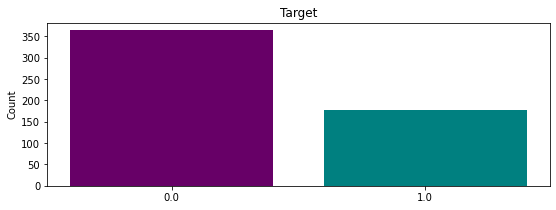

Target: 
 0.0    364
1.0    177
Name: Target, dtype: int64


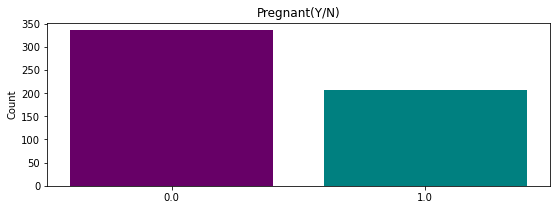

Pregnant(Y/N): 
 0.0    335
1.0    206
Name: Pregnant(Y/N), dtype: int64


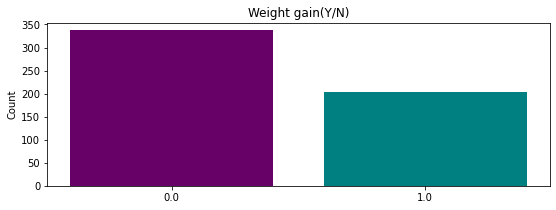

Weight gain(Y/N): 
 0.0    337
1.0    204
Name: Weight gain(Y/N), dtype: int64


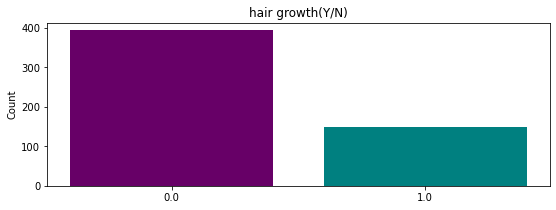

hair growth(Y/N): 
 0.0    393
1.0    148
Name: hair growth(Y/N), dtype: int64


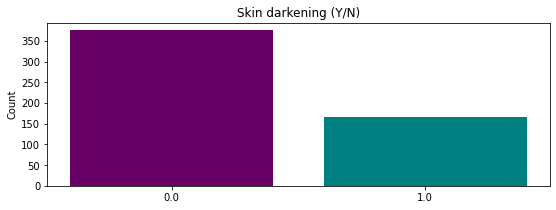

Skin darkening (Y/N): 
 0.0    375
1.0    166
Name: Skin darkening (Y/N), dtype: int64


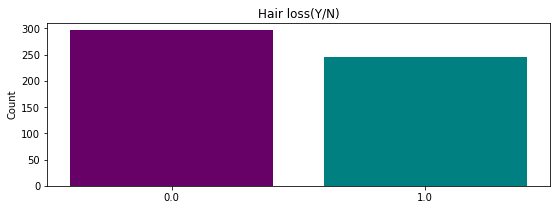

Hair loss(Y/N): 
 0.0    296
1.0    245
Name: Hair loss(Y/N), dtype: int64


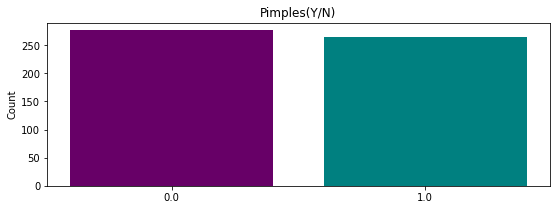

Pimples(Y/N): 
 0.0    276
1.0    265
Name: Pimples(Y/N), dtype: int64


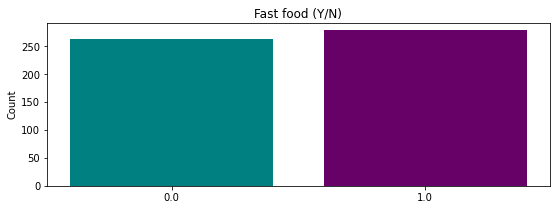

Fast food (Y/N): 
 1.0    278
0.0    262
Name: Fast food (Y/N), dtype: int64


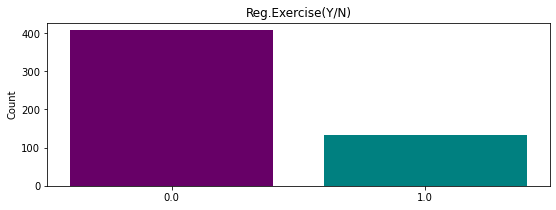

Reg.Exercise(Y/N): 
 0.0    407
1.0    134
Name: Reg.Exercise(Y/N), dtype: int64


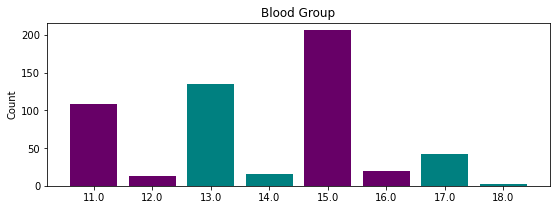

Blood Group: 
 15.0    206
13.0    135
11.0    108
17.0     42
16.0     19
14.0     16
12.0     13
18.0      2
Name: Blood Group, dtype: int64


In [15]:
category = ["Target", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", 
            "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for c in category:
    bar_plot(c)

In [16]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[0])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

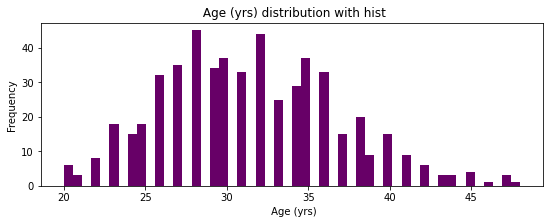

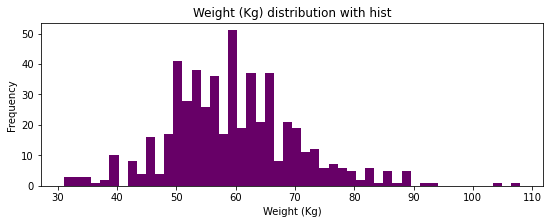

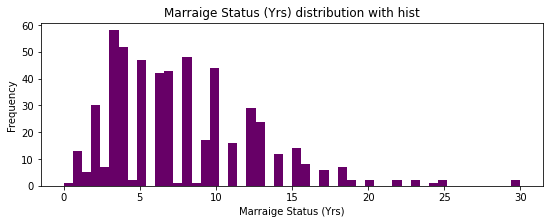

In [17]:
numericVar = [" Age (yrs)", "Weight (Kg)","Marraige Status (Yrs)"]
for n in numericVar:
    plot_hist(n)

In [18]:
data.columns[data.isnull().any()]

Index(['Marraige Status (Yrs)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)',
       'Fast food (Y/N)'],
      dtype='object')

In [19]:
 #Filling missing values with the median value of the features.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)


In [20]:
data.isnull().sum()

Target                    0
 Age (yrs)                0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     0
Pregnant(Y/N)             0
No. of aborptions         0
  I   beta-HCG(mIU/mL)    0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           0
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg) 

In [21]:
data.describe()

Target   Age (yrs)  Weight (Kg)  Height(Cm)          BMI  \
count  541.000000  541.000000   541.000000   541.000000  541.000000   
mean     0.327172   31.430684    59.637153   156.484835   24.311285   
std      0.469615    5.411006    11.028287     6.033545    4.056399   
min      0.000000   20.000000    31.000000   137.000000   12.417882   
25%      0.000000   28.000000    52.000000   152.000000   21.641274   
50%      0.000000   31.000000    59.000000   156.000000   24.238227   
75%      1.000000   35.000000    65.000000   160.000000   26.634958   
max      1.000000   48.000000   108.000000   180.000000   38.900000   

       Blood Group  Pulse rate(bpm)   RR (breaths/min)    Hb(g/dl)  \
count   541.000000        541.000000        541.000000  541.000000   
mean     13.802218         73.247689         19.243993   11.160037   
std       1.840812          4.430285          1.688629    0.866904   
min      11.000000         13.000000         16.000000    8.500000   
25%      13.000000         72.000000         18.000000   10.500000   
50%      14.000000         72.000000         18.000000   11.000000   
75%      15.000000         74.000000         20.000000   11.700000   
max      18.000000         82.000000         28.000000   14.800000   

       Cycle(R/I)  ...  Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  \
count  541.000000  ...    541.000000       541.000000         541.000000   
mean     2.560074  ...      0.489834         0.515712           0.247689   
std      0.901950  ...      0.500359         0.500216           0.432070   
min      2.000000  ...      0.000000         0.000000           0.000000   
25%      2.000000  ...      0.000000         0.000000           0.000000   
50%      2.000000  ...      0.000000         1.000000           0.000000   
75%      4.000000  ...      1.000000         1.000000           0.000000   
max      5.000000  ...      1.000000         1.000000           1.000000   

       BP _Systolic (mmHg)  BP _Diastolic (mmHg)  Follicle No. (L)  \
count           541.000000            541.000000        541.000000   
mean            114.661738             76.927911          6.129390   
std               7.384556              5.574112          4.229294   
min              12.000000              8.000000          0.000000   
25%             110.000000             70.000000          3.000000   
50%             110.000000             80.000000          5.000000   
75%             120.000000             80.000000          9.000000   
max             140.000000            100.000000         22.000000   

       Follicle No. (R)  Avg. F size (L) (mm)  Avg. F size (R) (mm)  \
count        541.000000            541.000000            541.000000   
mean           6.641405             15.018115             15.451701   
std            4.436889              3.566839              3.318848   
min            0.000000              0.000000              0.000000   
25%            3.000000             13.000000             13.000000   
50%            6.000000             15.000000             16.000000   
75%           10.000000             18.000000             18.000000   
max           20.000000             24.000000             24.000000   

       Endometrium (mm)  
count        541.000000  
mean           8.475915  
std            2.165381  
min            0.000000  
25%            7.000000  
50%            8.500000  
75%            9.800000  
max           18.000000  

[8 rows x 42 columns]

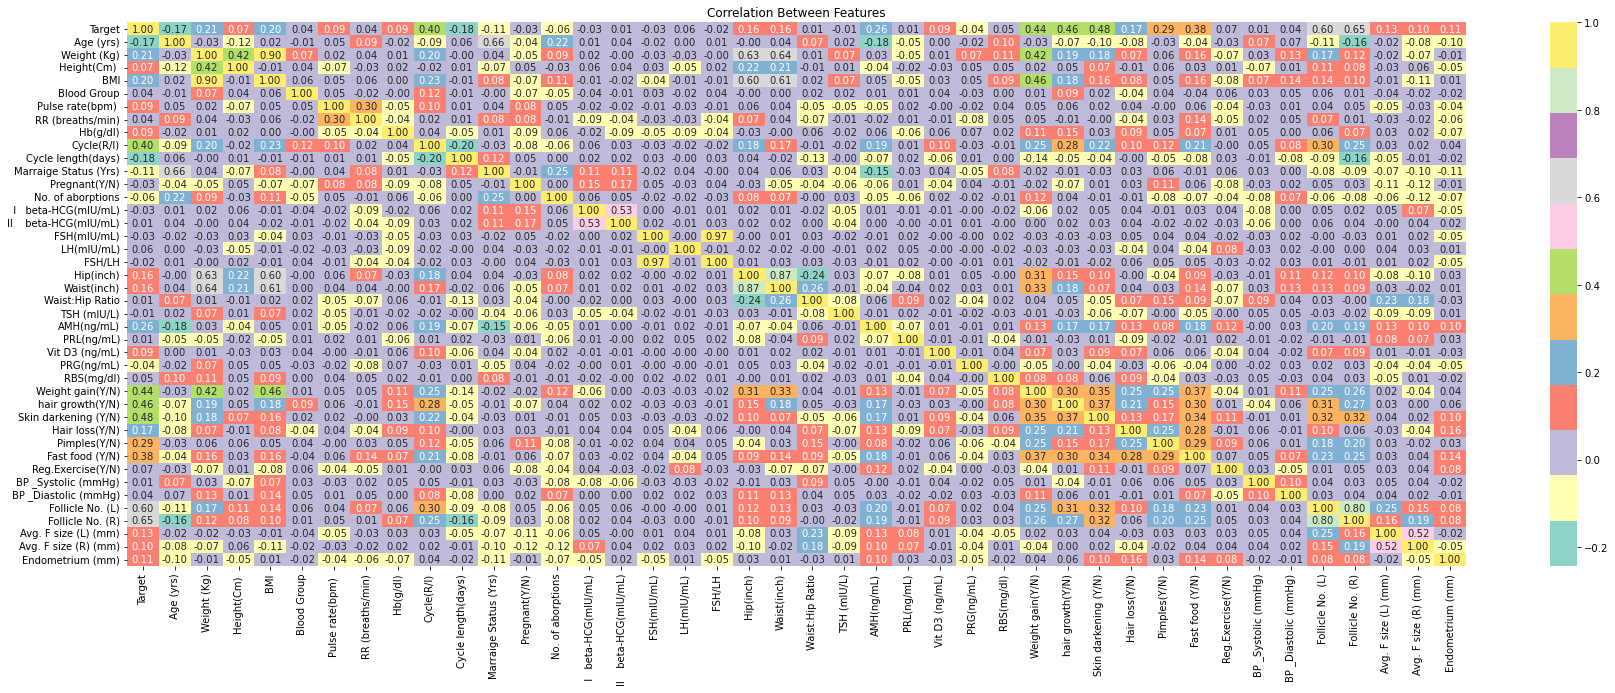

In [22]:
corr_matrix= data.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(corr_matrix,cmap="Set3", annot = True, fmt = ".2f");
plt.title("Correlation Between Features")
plt.show()

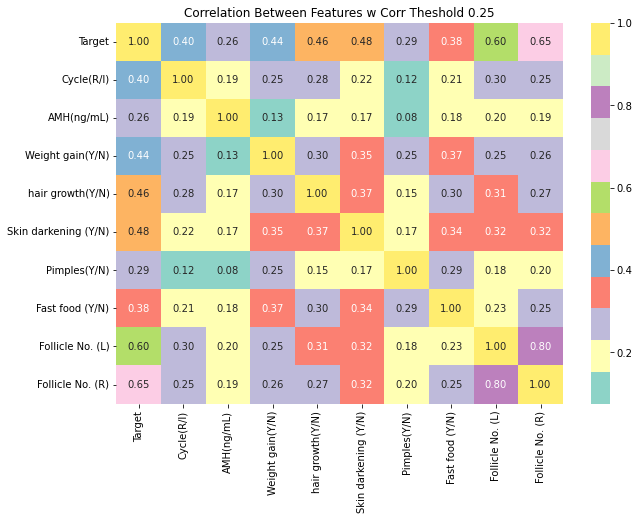

In [23]:
threshold = 0.25 
filtre = np.abs(corr_matrix["Target"]) > threshold 
corr_features = corr_matrix.columns[filtre].tolist()
plt.subplots(figsize=(10,7))
sns.heatmap(data[corr_features].corr(),cmap="Set3", annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.25")
plt.show()

In [24]:
X= data.drop(labels = ["Target"],axis = 1)
y=data.Target

In [25]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 

In [26]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 378
X_test 163
y_train 378
y_test 163


In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 85.45
Testing Accuracy: % 84.05


In [28]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}


classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [29]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(round(clf.best_score_*100,2))
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
80.41
Fitting 10 folds for each of 28 candidates, totalling 280 fits
70.63
Fitting 10 folds for each of 48 candidates, totalling 480 fits
89.67
Fitting 10 folds for each of 14 candidates, totalling 140 fits
83.85
Fitting 10 folds for each of 40 candidates, totalling 400 fits
71.93


In [30]:
best_estimators

[DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42),
 SVC(C=1, gamma=0.001, random_state=42),
 RandomForestClassifier(max_depth=12, n_estimators=500, random_state=42),
 LogisticRegression(C=100.0, random_state=42),
 KNeighborsClassifier(metric='manhattan')]

In [31]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

In [32]:
# xgbrf classifier
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=random_state)
xgb_clf.fit(X_train,y_train)
acc_xgb_clf_train = round(xgb_clf.score(X_train, y_train)*100,2) 
acc_xgb_clf_test = round(xgb_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_xgb_clf_train)
print("Training Accuracy: % {}".format(acc_xgb_clf_train))
print("Testing Accuracy: % {}".format(acc_xgb_clf_test))

[01:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: % 89.42
Testing Accuracy: % 90.8


In [33]:
#CatBoost Classifier
cat_clf = CatBoostClassifier()
cat_clf.fit(X_train,y_train)
acc_cat_clf_train = round(cat_clf.score(X_train, y_train)*100,2) 
acc_cat_clf_test = round(cat_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_cat_clf_train)
print("Training Accuracy: % {}".format(acc_cat_clf_train))
print("Testing Accuracy: % {}".format(acc_cat_clf_test))

Learning rate set to 0.0068
0:	learn: 0.6890949	total: 233ms	remaining: 3m 52s
1:	learn: 0.6839284	total: 235ms	remaining: 1m 57s
2:	learn: 0.6781053	total: 238ms	remaining: 1m 19s
3:	learn: 0.6730463	total: 240ms	remaining: 59.8s
4:	learn: 0.6669813	total: 243ms	remaining: 48.3s
5:	learn: 0.6613600	total: 245ms	remaining: 40.6s
6:	learn: 0.6561585	total: 248ms	remaining: 35.2s
7:	learn: 0.6517483	total: 250ms	remaining: 31s
8:	learn: 0.6466300	total: 253ms	remaining: 27.8s
9:	learn: 0.6427354	total: 255ms	remaining: 25.3s
10:	learn: 0.6377514	total: 258ms	remaining: 23.2s
11:	learn: 0.6333592	total: 260ms	remaining: 21.4s
12:	learn: 0.6296016	total: 262ms	remaining: 19.9s
13:	learn: 0.6244391	total: 265ms	remaining: 18.7s
14:	learn: 0.6193301	total: 267ms	remaining: 17.5s
15:	learn: 0.6160017	total: 269ms	remaining: 16.6s
16:	learn: 0.6117932	total: 272ms	remaining: 15.7s
17:	learn: 0.6090478	total: 274ms	remaining: 15s
18:	learn: 0.6044960	total: 277ms	remaining: 14.3s
19:	learn: 0.6

224:	learn: 0.2372693	total: 746ms	remaining: 2.57s
225:	learn: 0.2365003	total: 748ms	remaining: 2.56s
226:	learn: 0.2358358	total: 750ms	remaining: 2.56s
227:	learn: 0.2352709	total: 752ms	remaining: 2.55s
228:	learn: 0.2344931	total: 755ms	remaining: 2.54s
229:	learn: 0.2338786	total: 758ms	remaining: 2.54s
230:	learn: 0.2333734	total: 760ms	remaining: 2.53s
231:	learn: 0.2325877	total: 763ms	remaining: 2.52s
232:	learn: 0.2319954	total: 765ms	remaining: 2.52s
233:	learn: 0.2312264	total: 768ms	remaining: 2.51s
234:	learn: 0.2305909	total: 771ms	remaining: 2.51s
235:	learn: 0.2301429	total: 774ms	remaining: 2.5s
236:	learn: 0.2296790	total: 776ms	remaining: 2.5s
237:	learn: 0.2291624	total: 779ms	remaining: 2.49s
238:	learn: 0.2285137	total: 781ms	remaining: 2.49s
239:	learn: 0.2274345	total: 783ms	remaining: 2.48s
240:	learn: 0.2268770	total: 786ms	remaining: 2.48s
241:	learn: 0.2261052	total: 789ms	remaining: 2.47s
242:	learn: 0.2253213	total: 792ms	remaining: 2.47s
243:	learn: 0.

443:	learn: 0.1452850	total: 1.24s	remaining: 1.56s
444:	learn: 0.1450523	total: 1.25s	remaining: 1.55s
445:	learn: 0.1448456	total: 1.25s	remaining: 1.55s
446:	learn: 0.1443191	total: 1.25s	remaining: 1.55s
447:	learn: 0.1440379	total: 1.25s	remaining: 1.54s
448:	learn: 0.1437894	total: 1.25s	remaining: 1.54s
449:	learn: 0.1434231	total: 1.26s	remaining: 1.54s
450:	learn: 0.1432653	total: 1.26s	remaining: 1.53s
451:	learn: 0.1429621	total: 1.26s	remaining: 1.53s
452:	learn: 0.1425953	total: 1.27s	remaining: 1.53s
453:	learn: 0.1423329	total: 1.27s	remaining: 1.52s
454:	learn: 0.1421481	total: 1.29s	remaining: 1.55s
455:	learn: 0.1417722	total: 1.3s	remaining: 1.55s
456:	learn: 0.1415569	total: 1.3s	remaining: 1.54s
457:	learn: 0.1413628	total: 1.3s	remaining: 1.54s
458:	learn: 0.1410509	total: 1.3s	remaining: 1.54s
459:	learn: 0.1408072	total: 1.3s	remaining: 1.53s
460:	learn: 0.1405776	total: 1.31s	remaining: 1.53s
461:	learn: 0.1402973	total: 1.31s	remaining: 1.52s
462:	learn: 0.140

606:	learn: 0.1088128	total: 1.58s	remaining: 1.03s
607:	learn: 0.1085764	total: 1.59s	remaining: 1.02s
608:	learn: 0.1083287	total: 1.59s	remaining: 1.02s
609:	learn: 0.1081960	total: 1.59s	remaining: 1.02s
610:	learn: 0.1080883	total: 1.59s	remaining: 1.01s
611:	learn: 0.1078503	total: 1.59s	remaining: 1.01s
612:	learn: 0.1076150	total: 1.6s	remaining: 1.01s
613:	learn: 0.1074663	total: 1.6s	remaining: 1.01s
614:	learn: 0.1071751	total: 1.6s	remaining: 1s
615:	learn: 0.1070336	total: 1.61s	remaining: 1s
616:	learn: 0.1067908	total: 1.61s	remaining: 999ms
617:	learn: 0.1066704	total: 1.61s	remaining: 996ms
618:	learn: 0.1065110	total: 1.61s	remaining: 993ms
619:	learn: 0.1063769	total: 1.61s	remaining: 990ms
620:	learn: 0.1061415	total: 1.62s	remaining: 987ms
621:	learn: 0.1059672	total: 1.62s	remaining: 984ms
622:	learn: 0.1058751	total: 1.62s	remaining: 982ms
623:	learn: 0.1055707	total: 1.63s	remaining: 979ms
624:	learn: 0.1054253	total: 1.63s	remaining: 977ms
625:	learn: 0.1053198

815:	learn: 0.0808958	total: 2.09s	remaining: 472ms
816:	learn: 0.0807052	total: 2.1s	remaining: 469ms
817:	learn: 0.0805368	total: 2.1s	remaining: 467ms
818:	learn: 0.0804847	total: 2.1s	remaining: 464ms
819:	learn: 0.0803053	total: 2.1s	remaining: 462ms
820:	learn: 0.0802235	total: 2.1s	remaining: 459ms
821:	learn: 0.0800522	total: 2.11s	remaining: 456ms
822:	learn: 0.0799410	total: 2.11s	remaining: 454ms
823:	learn: 0.0797687	total: 2.11s	remaining: 452ms
824:	learn: 0.0797307	total: 2.12s	remaining: 449ms
825:	learn: 0.0796023	total: 2.12s	remaining: 446ms
826:	learn: 0.0795150	total: 2.12s	remaining: 444ms
827:	learn: 0.0794857	total: 2.12s	remaining: 441ms
828:	learn: 0.0793183	total: 2.13s	remaining: 438ms
829:	learn: 0.0791961	total: 2.13s	remaining: 436ms
830:	learn: 0.0790813	total: 2.13s	remaining: 433ms
831:	learn: 0.0789649	total: 2.13s	remaining: 430ms
832:	learn: 0.0788475	total: 2.13s	remaining: 428ms
833:	learn: 0.0788349	total: 2.14s	remaining: 425ms
834:	learn: 0.078

981:	learn: 0.0637095	total: 2.43s	remaining: 44.6ms
982:	learn: 0.0636147	total: 2.44s	remaining: 42.1ms
983:	learn: 0.0634507	total: 2.44s	remaining: 39.6ms
984:	learn: 0.0634442	total: 2.44s	remaining: 37.1ms
985:	learn: 0.0634298	total: 2.44s	remaining: 34.7ms
986:	learn: 0.0633415	total: 2.44s	remaining: 32.2ms
987:	learn: 0.0632507	total: 2.44s	remaining: 29.7ms
988:	learn: 0.0631392	total: 2.45s	remaining: 27.2ms
989:	learn: 0.0631271	total: 2.45s	remaining: 24.7ms
990:	learn: 0.0630145	total: 2.45s	remaining: 22.3ms
991:	learn: 0.0629090	total: 2.45s	remaining: 19.8ms
992:	learn: 0.0627697	total: 2.46s	remaining: 17.3ms
993:	learn: 0.0626290	total: 2.46s	remaining: 14.8ms
994:	learn: 0.0625125	total: 2.46s	remaining: 12.4ms
995:	learn: 0.0623904	total: 2.46s	remaining: 9.89ms
996:	learn: 0.0622943	total: 2.46s	remaining: 7.42ms
997:	learn: 0.0622853	total: 2.47s	remaining: 4.94ms
998:	learn: 0.0622678	total: 2.47s	remaining: 2.47ms
999:	learn: 0.0621650	total: 2.47s	remaining: 

In [34]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','KNearestNeighbours','XGBRF','CatBoostClassifier']

In [35]:
import plotly.graph_objects as go
# create trace1
trace1 = go.Bar(
                x = model_list,
                y = cv_result,
                marker = dict(color = 'rgb(0, 128, 128)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title = 'Accuracy of different Classifier Models' , xaxis = dict(title = 'Classifier Models'), yaxis = dict(title = '% of Accuracy'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [36]:
model = [dt,svm,rf,lr,knn,xgb_clf,cat_clf]
predictions = []

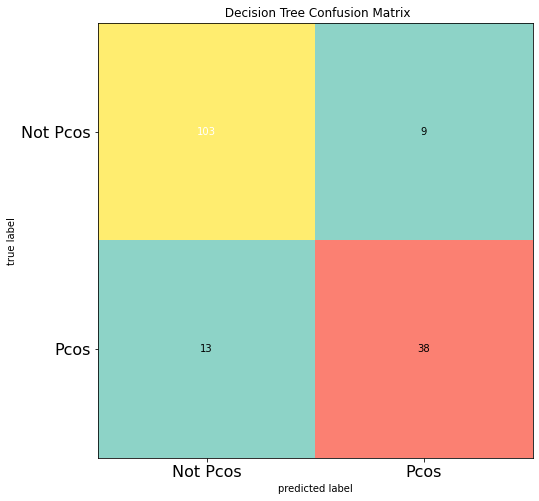

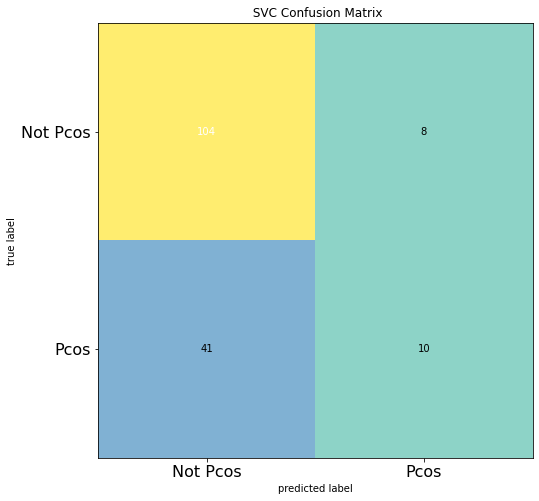

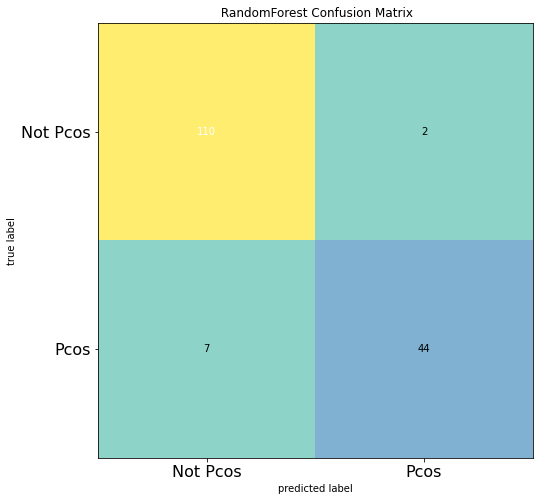

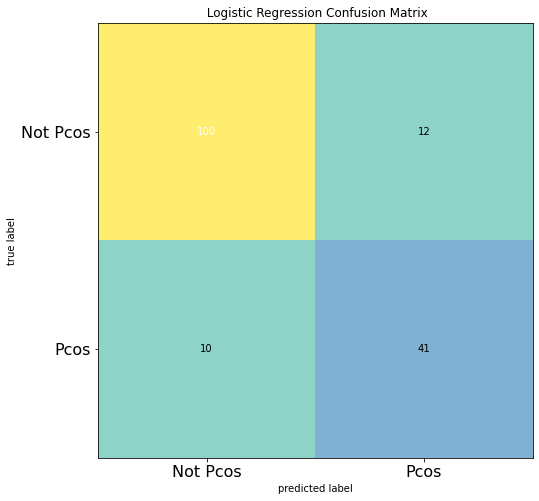

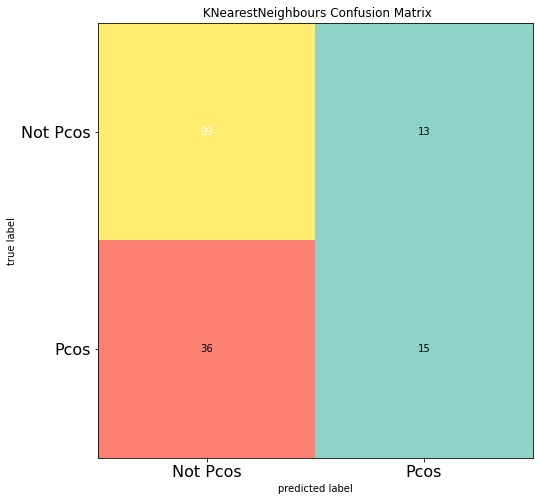

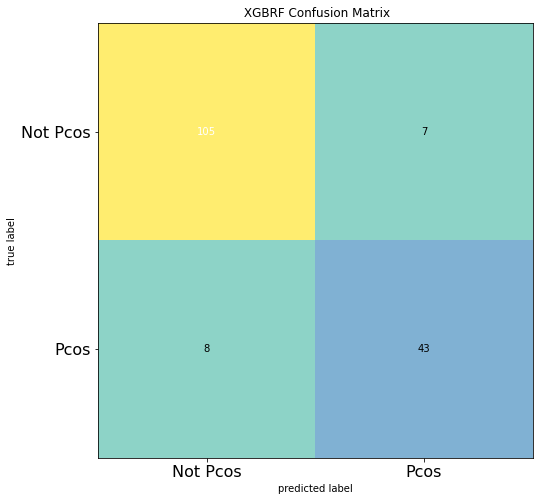

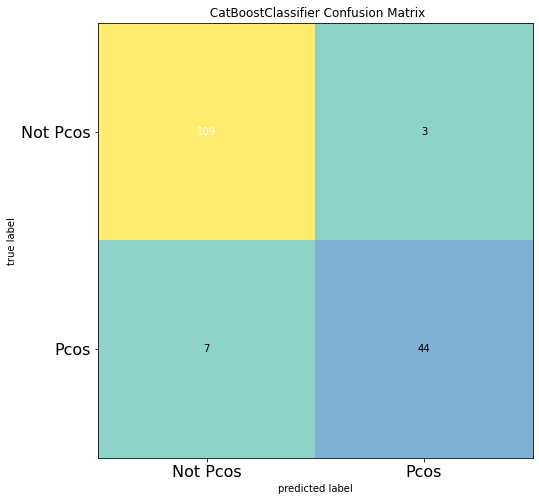

In [37]:
for i in model:
    predictions.append(i.predict(X_test))
for j in range(7):
    cm = confusion_matrix(y_test, predictions[j])
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Set3)
    plt.title(" {} Confusion Matrix".format(model_list[j]))
    plt.xticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.yticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.show()

In [38]:
cat_clf

In [39]:
!pip install sklearn
import joblib
joblib.dump(cat_clf, 'cat_clf.pkl')

  Using cached sklearn-0.0-py2.py3-none-any.whl


['cat_clf.pkl']

In [ ]:
!pip install google-colab
from google.colab import files
files.download("cat_clf.pkl")

In [40]:
X_train

Age (yrs)  Weight (Kg)  Height(Cm)         BMI  Blood Group  \
456        31.0         51.0        156.0  21.000000         17.0   
529        32.0         52.0        163.0  19.600000         13.0   
432        29.0         50.0        148.0  22.800000         15.0   
498        23.0         52.0        148.0  23.700000         15.0   
454        35.0         61.0        158.0  24.400000         13.0   
..          ...          ...          ...        ...          ...   
506        35.0         42.0        152.4  18.100000         11.0   
252        47.0         62.7        154.0  26.437848         15.0   
444        27.0         52.0        150.0  23.100000         11.0   
322        28.0         61.0        150.0  27.100000         11.0   
265        40.0         32.0        152.0  13.850416         15.0   

     Pulse rate(bpm)   RR (breaths/min)  Hb(g/dl)  Cycle(R/I)  \
456              78.0              20.0      11.1         2.0   
529              70.0              24.0      10.8         2.0   
432              72.0              22.0      11.0         2.0   
498              72.0              20.0      11.0         2.0   
454              72.0              18.0      10.5         2.0   
..                ...               ...       ...         ...   
506              78.0              18.0      10.8         2.0   
252              72.0              18.0      10.0         4.0   
444              82.0              20.0      11.1         2.0   
322              72.0              24.0      10.8         2.0   
265              72.0              20.0      10.0         2.0   

     Cycle length(days)  ...  Pimples(Y/N)  Fast food (Y/N)  \
456                 6.0  ...           1.0              0.0   
529                 6.0  ...           0.0              1.0   
432                 5.0  ...           1.0              0.0   
498                 5.0  ...           0.0              0.0   
454                 5.0  ...           1.0              1.0   
..                  ...  ...           ...              ...   
506                 5.0  ...           0.0              0.0   
252                 4.0  ...           0.0              0.0   
444                 5.0  ...           0.0              1.0   
322                 6.0  ...           1.0              1.0   
265                 3.0  ...           0.0              1.0   

     Reg.Exercise(Y/N)  BP _Systolic (mmHg)  BP _Diastolic (mmHg)  \
456                1.0                120.0                  70.0   
529                0.0                120.0                  80.0   
432                0.0                120.0                  70.0   
498                0.0                120.0                  80.0   
454                1.0                120.0                  80.0   
..                 ...                  ...                   ...   
506                0.0                120.0                  80.0   
252                0.0                110.0                  80.0   
444                1.0                120.0                  80.0   
322                0.0                110.0                  80.0   
265                1.0                120.0                  80.0   

     Follicle No. (L)  Follicle No. (R)  Avg. F size (L) (mm)  \
456              14.0              10.0                  17.0   
529               3.0               1.0                  18.0   
432               4.0               6.0                  10.0   
498               1.0               1.0                   7.0   
454              12.0              13.0                  19.0   
..                ...               ...                   ...   
506               3.0              10.0                  16.0   
252              14.0              11.0                  16.0   
444               1.0               1.0                  16.0   
322               7.0              11.0                  15.0   
265               6.0               5.0                  18.0   

     Avg. F size (R) (mm)  En

In [41]:
type(X_train)

pandas.core.frame.DataFrame

In [1]:
print(X_train)

NameError: name 'X_train' is not defined

In [2]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.
